In [329]:
    import fiona
    import os,os.path
    from shapely.geometry import shape,mapping
    from shapely.ops import transform
    from functools import partial
    import pyproj
    from fiona.crs import from_epsg
    import osmnx as ox
    import matplotlib.pyplot as plt
    import geopandas as gpd
    import glob
    import json
    import numpy as np
    import requests as rq
    import collections
    import logging
    import time
    from PIL import Image
    from io import BytesIO
    import pandas as pd
    import dateutil.parser
    from tqdm import tqdm
    import seaborn as sns
    %matplotlib inline

In [330]:
map_images = pd.read_csv('scratchpad/Mappilary_image_data_df_V3.csv')
map_features = pd.read_csv('scratchpad/Mapillary_20city_urban_features_Final.csv')

In [331]:
map_images['year'] = map_images['captureTime'].apply(lambda x: x.split('-')[0].strip())

In [332]:
map_images.head()

,Unnamed: 0,Imgkey,long,lat,isPano,captureTime,long_lat_string,city,year
0,0,LvAH_MniU5aoQcqGUSaRfg,24.929696,60.164457,False,2017-05-06T17:08:05.000Z,24.9297_60.1645,Helsinki,2017
1,1,I-UrvuxcsFzyOixxzKftXA,24.929745,60.164460,False,2016-12-13T08:30:47.671Z,24.9297_60.1645,Helsinki,2016
2,2,PLLDa2_eRgQMp3kciCYzEA,24.929622,60.164430,False,2017-05-06T17:08:04.000Z,24.9296_60.1644,Helsinki,2017
3,3,w35tfBtc8gOlIG3TK52Kag,24.929707,60.164380,False,2019-07-11T06:42:15.876Z,24.9297_60.1644,Helsinki,2019
4,4,3zWRV2aQtC1XES3hSyNtip,24.929800,60.164474,False,2020-08-13T18:23:35.000Z,24.9298_60.1645,Helsinki,2020


In [333]:
map_features.head(n=2)

,Unnamed: 0,ImgId,ObjEntropy,SceneEntropy,__background__,person,bicycle,car_coco,motorcycle,airplane,...,terrain,sky,person_enet,rider_enet,car_enet,truck_enet,bus_enet,train_enet,motorcycle_enet,bicycle_enet
0,0,pPbGnlvoqb88c9oYn068VH,0.049570,1.893505,0,0,0,1,0,0,...,0.018312,0.011059,0.006845,0.000417,0.162331,0.024518,0.018472,0.009128,0.004870,0.016957
1,1,uDQnOWWRqR0e3e9Gdca5lw,0.521312,1.799529,0,2,5,13,0,0,...,0.004219,0.005264,0.124756,0.008413,0.058877,0.047642,0.000078,0.001445,0.004077,0.063989


In [334]:
city_images = []
city_name = []
city_years = {}
for name , group in map_images.groupby('city'):
    city_images.append(len(set(group['long_lat_string'])))
    city_name.append(name)

In [335]:
year_images = []
year  = []
for name , group in map_images.groupby('year'):
    year_images.append(len(group))
    year.append(name)

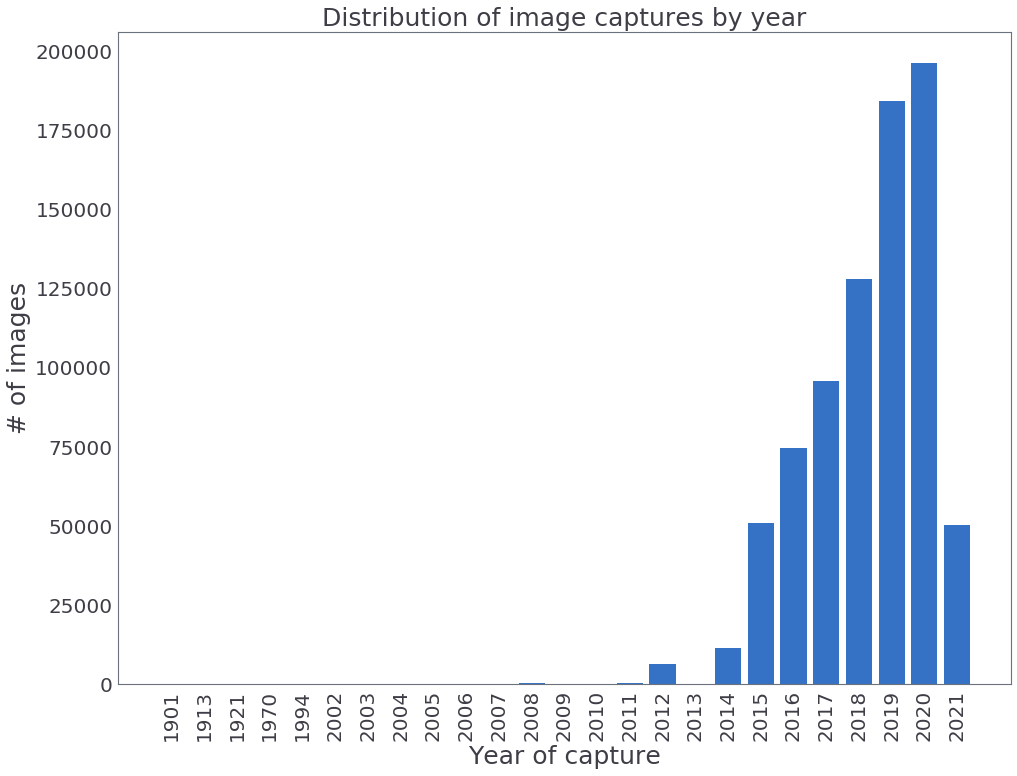

In [336]:
x = np.arange(len(year))
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
plt.grid()
plt.bar(x, year_images)
plt.title('Distribution of image captures by year',fontsize=25)
plt.yticks(fontsize=20)
plt.ylabel('# of images',fontsize=25)
plt.xticks(x, year ,rotation=90,fontsize=20)
plt.xlabel('Year of capture',fontsize=25)
plt.show()

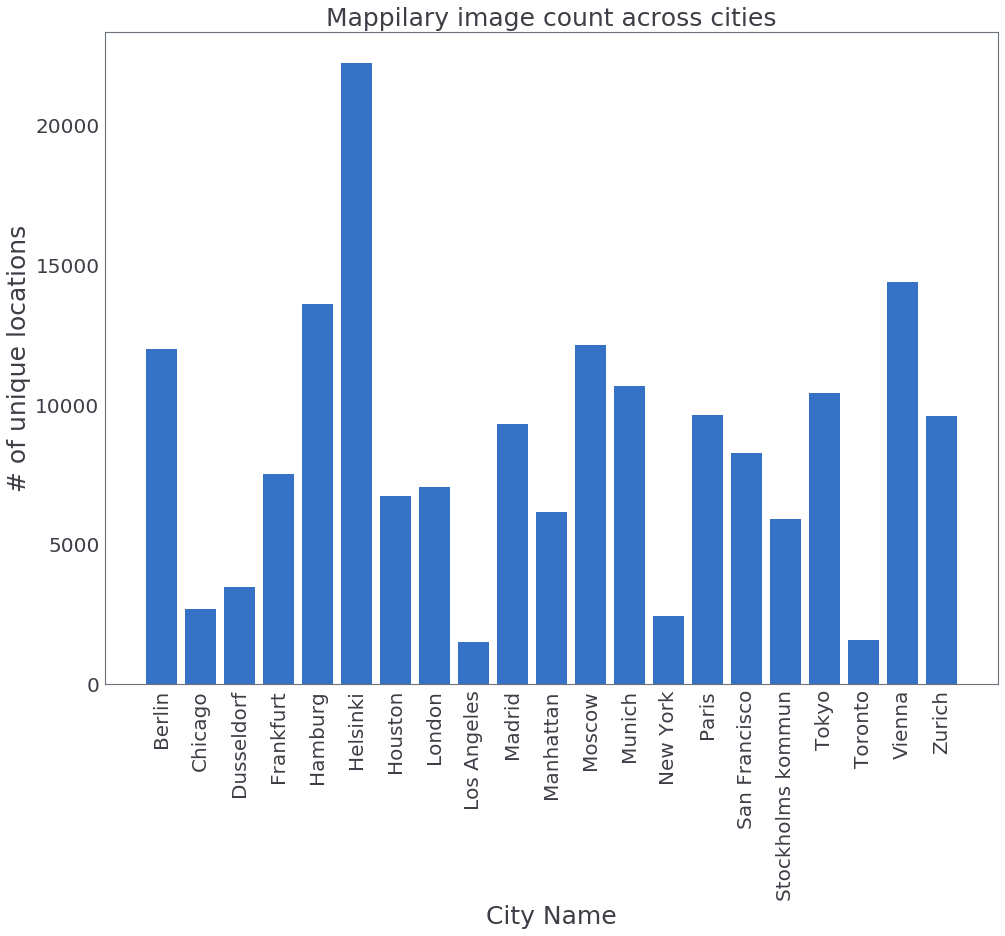

In [337]:
x = np.arange(len(city_name))
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
plt.grid()
plt.bar(x, city_images)
plt.title('Mappilary image count across cities',fontsize=25)
plt.yticks(fontsize=20)
plt.ylabel('# of unique locations',fontsize=25)
plt.xticks(x, city_name ,rotation=90,fontsize=20)
plt.xlabel('City Name',fontsize=25)
plt.show()

In [338]:
total_mappilary_df = pd.merge(map_images,map_features,left_on='Imgkey',right_on='ImgId')

In [339]:
def Entropy(array):
    classProb = [k/(sum(array)+1) for k in array]
    entropy = - sum([classProb[i]*np.log(classProb[i]) for i in range(len(classProb)) if classProb[i] > 0 ])
    return entropy

def Entropy_new(array):
    entropy = - sum([array[i]*np.log(array[i]) for i in range(len(array)) if array[i] > 0 ])
    return entropy

In [340]:
len(total_mappilary_df)

798244

In [341]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car_coco', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant',  'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator',  'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

countDict = {}
for k in COCO_INSTANCE_CATEGORY_NAMES:
    countDict[k] = sum(total_mappilary_df[k])

In [342]:
dict(sorted(countDict.items(), key=lambda item: item[1]))

{'__background__': 0,
 'sandwich': 2,
 'hot dog': 3,
 'toaster': 3,
 'pizza': 21,
 'hair drier': 24,
 'zebra': 31,
 'carrot': 36,
 'orange': 38,
 'apple': 68,
 'giraffe': 69,
 'banana': 79,
 'bear': 85,
 'donut': 85,
 'scissors': 105,
 'fork': 129,
 'cake': 138,
 'spoon': 141,
 'broccoli': 168,
 'toothbrush': 257,
 'baseball glove': 263,
 'toilet': 263,
 'sheep': 264,
 'snowboard': 284,
 'oven': 290,
 'wine glass': 292,
 'microwave': 311,
 'baseball bat': 312,
 'teddy bear': 349,
 'cat': 411,
 'knife': 422,
 'bed': 466,
 'couch': 487,
 'tennis racket': 495,
 'tie': 499,
 'skis': 507,
 'keyboard': 511,
 'elephant': 662,
 'remote': 667,
 'laptop': 681,
 'bowl': 958,
 'frisbee': 982,
 'surfboard': 1019,
 'sink': 1019,
 'cow': 1618,
 'cell phone': 1733,
 'vase': 1851,
 'airplane': 2060,
 'refrigerator': 2072,
 'kite': 2127,
 'dog': 2836,
 'cup': 3449,
 'dining table': 3481,
 'mouse': 3619,
 'parking meter': 4230,
 'sports ball': 4738,
 'skateboard': 4955,
 'bird': 5577,
 'suitcase': 5886,


In [343]:
segnetDict = {'Car_Infrastructure_enet' : ['road', 'pole_enet', 'traffic_light', 'traffic_sign', 'car_enet', 'truck_enet', 'bus_enet',  'motorcycle_enet'],
              'Pedestrians_enet': ['sidewalk', 'person_enet', 'bicycle_enet'],
              'Architecture_enet' : ['building', 'wall', 'fence_enet'],
              'Nature_enet': ['vegetation', 'terrain', 'sky']
             }



cocoDict = {'Car_Infrastructure_coco' : ['stop sign','boat','motorcycle','bus','truck','traffic light','car_coco'],
'Pedestrians_coco': ['umbrella','backpack','handbag','bicycle','person'],
# 'Architecture_coco' : ['clock','bench'],
# 'Nature_coco': ['horse','potted plant']
           }


In [344]:
placesNet_df = pd.read_csv('../Data/Mappilary_city_placesNet.csv')

In [345]:
placesNet_df['Walkable'] = placesNet_df['Walkable'] - 0.0001
placesNet_df['Landmark'] = placesNet_df['Landmark'] - 0.0002
placesNet_df['Architecture'] = placesNet_df['Architecture'] + 0.0001
placesNet_df['Natural'] = placesNet_df['Natural'] + 0.0002

In [346]:
placesNet_max =  placesNet_df[['Walkable' , 'Landmark', 'Architecture', 'Natural']].apply(lambda x: x == x.max(), axis=1).astype(int) 

In [347]:
placesNet_max.head(n=5)

,Walkable,Landmark,Architecture,Natural
0,0,1,0,0
1,0,0,1,0
2,1,0,0,0
3,0,0,1,0
4,0,0,1,0


In [348]:
placesNet_max.sum(axis=0)

Walkable        325767
Landmark         65957
Architecture    343501
Natural          63019
dtype: int64

In [349]:
placesNet_max.rename(columns={'Walkable':'W', 'Landmark':'L','Architecture':'A','Natural':'N'},inplace=True)

In [350]:
placesNet_df = pd.merge(placesNet_df, placesNet_max,left_index=True, right_index=True)

In [351]:
# placesNet_df['places_entropy'] = placesNet_df.apply(lambda x: Entropy_new([x[col] for col in ['Walkable' , 'Landmark', 'Architecture', 'Natural']]) , axis = 1 )

In [352]:
placesNet_df[['Architecture','Landmark','Natural','Walkable']].corr()

,Architecture,Landmark,Natural,Walkable
Architecture,1.000000,-0.238676,-0.186304,-0.475084
Landmark,-0.238676,1.000000,-0.006178,-0.404647
Natural,-0.186304,-0.006178,1.000000,-0.317282
Walkable,-0.475084,-0.404647,-0.317282,1.000000


In [353]:
placesNet_df.head()

,Unnamed: 0,Architecture,Landmark,N/A,Natural,Unnamed: 0.1,Walkable,imgKey,placesNet_labels,W,L,A,N
0,0,0.0001,0.5998,0.0,0.0002,0.0,0.3999,pPbGnlvoqb88c9oYn068VH,"['plaza', 'embassy', 'street', 'subway_station...",0,1,0,0
1,1,0.6001,0.1998,0.0,0.0002,1.0,0.1999,uDQnOWWRqR0e3e9Gdca5lw,"['residential_neighborhood', 'street', 'apartm...",0,0,1,0
2,2,0.2001,-0.0002,0.2,0.0002,2.0,0.5999,i9CFCOnZErlyETxBfVNgAA,"['street', 'alley', 'downtown', 'residential_n...",1,0,0,0
3,3,0.4001,-0.0002,0.2,0.0002,3.0,0.3999,JI9N8XEtaV7G66K0PFVo_g,"['downtown', 'street', 'crosswalk', 'parking_g...",0,0,1,0
4,4,0.4001,0.1998,0.0,0.0002,4.0,0.3999,y-0mK7IyYGb-1rW25PikrQ,"['crosswalk', 'highway', 'residential_neighbor...",0,0,1,0


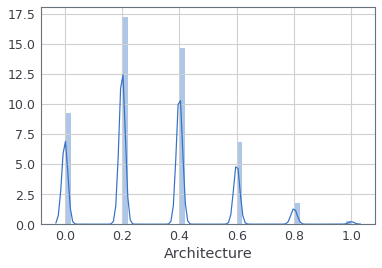

In [354]:
sns.distplot(placesNet_df['Architecture'])

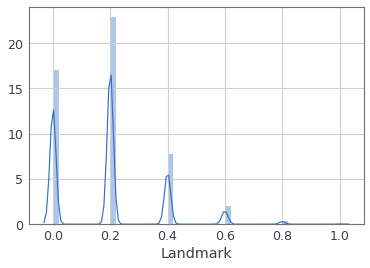

In [355]:
sns.distplot(placesNet_df['Landmark'])

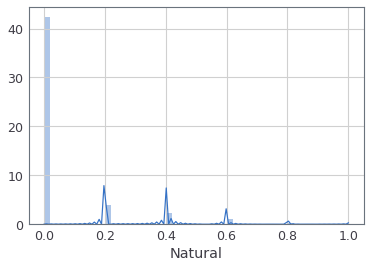

In [356]:
sns.distplot(placesNet_df['Natural'])

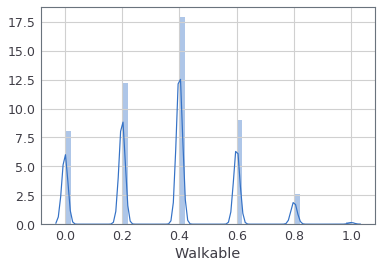

In [357]:
sns.distplot(placesNet_df['Walkable'])

In [358]:
placesNet_df.head()

,Unnamed: 0,Architecture,Landmark,N/A,Natural,Unnamed: 0.1,Walkable,imgKey,placesNet_labels,W,L,A,N
0,0,0.0001,0.5998,0.0,0.0002,0.0,0.3999,pPbGnlvoqb88c9oYn068VH,"['plaza', 'embassy', 'street', 'subway_station...",0,1,0,0
1,1,0.6001,0.1998,0.0,0.0002,1.0,0.1999,uDQnOWWRqR0e3e9Gdca5lw,"['residential_neighborhood', 'street', 'apartm...",0,0,1,0
2,2,0.2001,-0.0002,0.2,0.0002,2.0,0.5999,i9CFCOnZErlyETxBfVNgAA,"['street', 'alley', 'downtown', 'residential_n...",1,0,0,0
3,3,0.4001,-0.0002,0.2,0.0002,3.0,0.3999,JI9N8XEtaV7G66K0PFVo_g,"['downtown', 'street', 'crosswalk', 'parking_g...",0,0,1,0
4,4,0.4001,0.1998,0.0,0.0002,4.0,0.3999,y-0mK7IyYGb-1rW25PikrQ,"['crosswalk', 'highway', 'residential_neighbor...",0,0,1,0


In [359]:
placesNet_df_sub = placesNet_df[['imgKey','W','L','A','N']].copy()

In [360]:
total_mappilary_df

,Unnamed: 0_x,Imgkey,long,lat,isPano,captureTime,long_lat_string,city,year,Unnamed: 0_y,...,terrain,sky,person_enet,rider_enet,car_enet,truck_enet,bus_enet,train_enet,motorcycle_enet,bicycle_enet
0,0,LvAH_MniU5aoQcqGUSaRfg,24.929696,60.164457,False,2017-05-06T17:08:05.000Z,24.9297_60.1645,Helsinki,2017,273794,...,0.001921,0.020365,0.012210,0.000000,0.105762,0.001077,0.001657,0.176416,0.000003,0.000319
1,1,I-UrvuxcsFzyOixxzKftXA,24.929745,60.164460,False,2016-12-13T08:30:47.671Z,24.9297_60.1645,Helsinki,2016,325660,...,0.000521,0.165833,0.005837,0.000016,0.143255,0.021221,0.000020,0.000335,0.000007,0.001576
2,2,PLLDa2_eRgQMp3kciCYzEA,24.929622,60.164430,False,2017-05-06T17:08:04.000Z,24.9296_60.1644,Helsinki,2017,451898,...,0.002256,0.032744,0.015618,0.000000,0.071833,0.005407,0.003083,0.019287,0.002588,0.001973
3,3,w35tfBtc8gOlIG3TK52Kag,24.929707,60.164380,False,2019-07-11T06:42:15.876Z,24.9297_60.1644,Helsinki,2019,565304,...,0.005605,0.256953,0.053441,0.018994,0.057008,0.004512,0.010160,0.021195,0.000277,0.145479
4,4,3zWRV2aQtC1XES3hSyNtip,24.929800,60.164474,False,2020-08-13T18:23:35.000Z,24.9298_60.1645,Helsinki,2020,797752,...,0.001956,0.033532,0.038483,0.000046,0.059463,0.001761,0.001315,0.002311,0.001484,0.007780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798239,798239,v5aXOBlhKZxn340UoU9s2Q,-73.949991,40.673744,False,2019-01-28T00:31:14.972Z,-73.9500_40.6737,New York,2019,290750,...,0.000625,0.001094,0.027347,0.000260,0.281302,0.002327,0.000469,0.000065,0.000039,0.017025
798240,798240,o0fwkJx7lCDWhrTdB-4kkA,-73.949991,40.673767,False,2019-01-28T00:31:17.307Z,-73.9500_40.6738,New York,2019,398943,...,0.000075,0.057025,0.105033,0.038975,0.183587,0.181227,0.012204,0.002393,0.020371,0.031025
798241,798241,uP-grx7eGre5wYEjftYlOQ,-73.949990,40.673784,False,2019-01-28T00:31:21.939Z,-73.9500_40.6738,New York,2019,505713,...,0.000000,0.107155,0.085257,0.009574,0.063675,0.134785,0.009349,0.034912,0.038532,0.013682
798242,798242,j2OKZ3NNkOr54jxmb9PZ2A,-73.949991,40.673803,False,2019-01-28T00:31:23.947Z,-73.9500_40.6738,New York,2019,63347,...,0.000127,0.060462,0.140443,0.004255,0.058190,0.030811,0.003118,0.044030,0.001969,0.068473


In [361]:
total_mappilary_df = pd.merge(total_mappilary_df ,placesNet_df_sub ,left_on='Imgkey',right_on='imgKey')

In [362]:
for k in segnetDict:
    total_mappilary_df[k] = 0.0
    for tag in segnetDict[k]:
        total_mappilary_df[k]+=total_mappilary_df[tag]

In [363]:
for k in cocoDict:
    total_mappilary_df[k] = 0.0
    for tag in cocoDict[k]:
        total_mappilary_df[k]+=total_mappilary_df[tag]

In [364]:
print(list(total_mappilary_df.columns))

['Unnamed: 0_x', 'Imgkey', 'long', 'lat', 'isPano', 'captureTime', 'long_lat_string', 'city', 'year', 'Unnamed: 0_y', 'ImgId', 'ObjEntropy', 'SceneEntropy', '__background__', 'person', 'bicycle', 'car_coco', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', '

In [365]:
total_mappilary_df['segNet_entropy_new'] = total_mappilary_df.apply(lambda x: Entropy([x[col] for col in segnetDict.keys()]) , axis = 1 )

In [366]:
total_mappilary_df['coco_entropy_new'] = total_mappilary_df.apply(lambda x: Entropy([x[col] for col in cocoDict.keys()]) , axis = 1 )

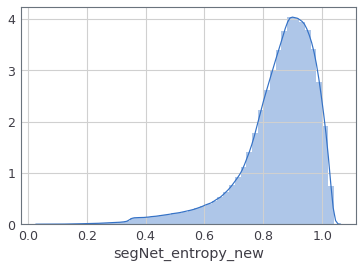

In [367]:
sns.distplot(total_mappilary_df['segNet_entropy_new'])

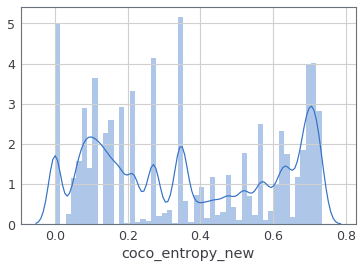

In [368]:
sns.distplot(total_mappilary_df['coco_entropy_new'])

In [369]:
city_road_entropy = pd.read_csv('scratchpad/City_entropy.csv')

In [370]:
city_road_entropy.head(n=2)

,city,street_entropy
0,New York,1.980912
1,Hamburg,2.207576


In [371]:
total_mappilary_df

,Unnamed: 0_x,Imgkey,long,lat,isPano,captureTime,long_lat_string,city,year,Unnamed: 0_y,...,A,N,Car_Infrastructure_enet,Pedestrians_enet,Architecture_enet,Nature_enet,Car_Infrastructure_coco,Pedestrians_coco,segNet_entropy_new,coco_entropy_new
0,0,LvAH_MniU5aoQcqGUSaRfg,24.929696,60.164457,False,2017-05-06T17:08:05.000Z,24.9297_60.1645,Helsinki,2017,273794,...,1,0,0.338753,0.024408,0.438138,0.022285,13.0,1.0,0.766874,0.304557
1,1,I-UrvuxcsFzyOixxzKftXA,24.929745,60.164460,False,2016-12-13T08:30:47.671Z,24.9297_60.1645,Helsinki,2016,325660,...,1,0,0.483802,0.008203,0.334961,0.172682,11.0,0.0,0.876680,0.079760
2,2,PLLDa2_eRgQMp3kciCYzEA,24.929622,60.164430,False,2017-05-06T17:08:04.000Z,24.9296_60.1644,Helsinki,2017,451898,...,1,0,0.396745,0.069014,0.479909,0.035046,10.0,1.0,0.853898,0.359010
3,3,w35tfBtc8gOlIG3TK52Kag,24.929707,60.164380,False,2019-07-11T06:42:15.876Z,24.9297_60.1644,Helsinki,2019,565304,...,0,0,0.216777,0.234333,0.238411,0.270290,12.0,3.0,1.026981,0.529632
4,4,3zWRV2aQtC1XES3hSyNtip,24.929800,60.164474,False,2020-08-13T18:23:35.000Z,24.9298_60.1645,Helsinki,2020,797752,...,1,0,0.542751,0.063883,0.355518,0.035492,9.0,0.0,0.842941,0.094824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798239,798239,v5aXOBlhKZxn340UoU9s2Q,-73.949991,40.673744,False,2019-01-28T00:31:14.972Z,-73.9500_40.6737,New York,2019,290750,...,1,0,0.398389,0.106833,0.489349,0.005104,3.0,2.0,0.837638,0.712778
798240,798240,o0fwkJx7lCDWhrTdB-4kkA,-73.949991,40.673767,False,2019-01-28T00:31:17.307Z,-73.9500_40.6738,New York,2019,398943,...,0,0,0.508923,0.152650,0.239941,0.057119,5.0,8.0,0.909364,0.687502
798241,798241,uP-grx7eGre5wYEjftYlOQ,-73.949990,40.673784,False,2019-01-28T00:31:21.939Z,-73.9500_40.6738,New York,2019,505713,...,0,0,0.349154,0.126852,0.372354,0.107155,7.0,5.0,0.960008,0.700833
798242,798242,j2OKZ3NNkOr54jxmb9PZ2A,-73.949991,40.673803,False,2019-01-28T00:31:23.947Z,-73.9500_40.6738,New York,2019,63347,...,0,0,0.190999,0.235651,0.464476,0.060589,7.0,5.0,0.932144,0.700833


In [376]:
from tqdm import tqdm
# city_dict = {'city': [] , 'objectEntropy_mean': [], 'SegnetEntropy_mean': [] , 'Car_Infrastructure_enet' : [] , 'Pedestrians_enet' : [] , 'Architecture_enet': [] , 'Nature_enet' : [],
#             'Car_Infrastructure_coco' : [] , 'Pedestrians_coco': [] , 'Walkability' : [] , 'Landmark':[], 'Architecture': [], 'Natural': [],
#             'Place_entropy':[]}
city_dict = {'city': [] , 'Car_Infrastructure_enet' : [] , 'Pedestrians_enet' : [] , 'Architecture_enet': [] , 'Nature_enet' : [],
             'Walkability' : [] , 'Landmark':[], 'Architecture': [], 'Natural': [], 'Place_entropy':[]}


for name , group in tqdm(total_mappilary_df.groupby('city')):
    city_dict['city'].append(name)
#     city_dict['objectEntropy_mean'].append(np.mean(group['coco_entropy_new']))
#     city_dict['SegnetEntropy_mean'].append(np.mean(group['segNet_entropy_new']))
    city_dict['Car_Infrastructure_enet'].append(np.mean(group['Car_Infrastructure_enet']))
    city_dict['Pedestrians_enet'].append(np.mean(group['Pedestrians_enet']))
    city_dict['Architecture_enet'].append(np.mean(group['Architecture_enet']))
    city_dict['Nature_enet'].append(np.mean(group['Nature_enet']))
#     city_dict['Car_Infrastructure_coco'].append(np.sum(group['Car_Infrastructure_coco']))
#     city_dict['Pedestrians_coco'].append(np.sum(group['Pedestrians_coco']))
#     city_dict['Architecture_coco'].append(np.sum(group['Architecture_coco']))
#     city_dict['Nature_coco'].append(np.sum(group['Nature_coco']))
    scene_dist = group[['W','L','A','N']].sum(axis=1).values
    city_dict['Place_entropy'].append(Entropy(scene_dist))
    city_dict['Natural'].append(np.sum(group['N'])/len(group))
    city_dict['Architecture'].append(np.sum(group['A'])/len(group))
    city_dict['Landmark'].append(np.sum(group['L'])/len(group))
    city_dict['Walkability'].append(np.sum(group['W'])/len(group))


city_mappilary_df = pd.DataFrame.from_dict(city_dict)

100%|██████████| 21/21 [2:27:24<00:00, 421.16s/it]  


In [377]:
city_mappilary_df = pd.merge(city_mappilary_df,city_road_entropy,left_on='city' , right_on='city')

In [378]:
city_mappilary_df

,city,Car_Infrastructure_enet,Pedestrians_enet,Architecture_enet,Nature_enet,Walkability,Landmark,Architecture,Natural,Place_entropy,street_entropy
0,Berlin,0.423378,0.096035,0.219201,0.244559,0.244141,0.026775,0.659220,0.069863,10.943270,3.430909
1,Chicago,0.302553,0.088358,0.152131,0.435303,0.112160,0.052598,0.711720,0.123522,9.296950,2.671477
2,Dusseldorf,0.319405,0.091264,0.284240,0.287618,0.328217,0.066750,0.507050,0.097983,8.629696,3.506124
3,Frankfurt,0.306747,0.124709,0.316827,0.197020,0.254265,0.100275,0.542619,0.102841,10.227554,3.440617
4,Hamburg,0.417139,0.118985,0.236723,0.183411,0.525574,0.055517,0.370925,0.047984,11.273446,2.207576
5,Helsinki,0.335996,0.144628,0.257337,0.096660,0.401408,0.071388,0.468998,0.058206,11.603967,3.570721
6,Houston,0.421484,0.064195,0.266656,0.222102,0.051555,0.187703,0.275740,0.485003,9.904891,2.864279
7,London,0.404137,0.131916,0.240396,0.169135,0.435397,0.103027,0.397364,0.064211,9.717657,3.559425
8,Los Angeles,0.304894,0.102096,0.214451,0.370784,0.075706,0.007592,0.260439,0.656263,8.462641,3.477084
9,Madrid,0.277816,0.102116,0.376015,0.169309,0.357968,0.036180,0.557530,0.048323,9.907733,3.502409


In [379]:
city_mappilary_df.corr()

,Car_Infrastructure_enet,Pedestrians_enet,Architecture_enet,Nature_enet,Walkability,Landmark,Architecture,Natural,Place_entropy,street_entropy
Car_Infrastructure_enet,1.000000,-0.125050,-0.415167,-0.343454,0.390343,0.164412,-0.247091,-0.208808,0.254729,-0.348504
Pedestrians_enet,-0.125050,1.000000,0.116560,-0.512768,0.385474,-0.054151,0.022877,-0.375769,0.253197,0.268918
Architecture_enet,-0.415167,0.116560,1.000000,-0.483714,0.182420,0.291458,-0.139916,-0.140126,0.323149,0.515435
Nature_enet,-0.343454,-0.512768,-0.483714,1.000000,-0.672656,-0.311658,0.250465,0.522077,-0.653046,-0.324477
Walkability,0.390343,0.385474,0.182420,-0.672656,1.000000,0.042212,-0.332096,-0.685911,0.477248,0.019265
Landmark,0.164412,-0.054151,0.291458,-0.311658,0.042212,1.000000,-0.480189,0.082378,0.326140,0.222454
Architecture,-0.247091,0.022877,-0.139916,0.250465,-0.332096,-0.480189,1.000000,-0.413697,-0.101741,-0.096749
Natural,-0.208808,-0.375769,-0.140126,0.522077,-0.685911,0.082378,-0.413697,1.000000,-0.468358,-0.000035
Place_entropy,0.254729,0.253197,0.323149,-0.653046,0.477248,0.326140,-0.101741,-0.468358,1.000000,0.251780
street_entropy,-0.348504,0.268918,0.515435,-0.324477,0.019265,0.222454,-0.096749,-0.000035,0.251780,1.000000


[Text(0, 0.5, 'Car_Infrastructure_enet'),
 Text(0, 1.5, 'Pedestrians_enet'),
 Text(0, 2.5, 'Architecture_enet'),
 Text(0, 3.5, 'Nature_enet'),
 Text(0, 4.5, 'Walkability'),
 Text(0, 5.5, 'Landmark'),
 Text(0, 6.5, 'Architecture'),
 Text(0, 7.5, 'Natural'),
 Text(0, 8.5, 'Place_entropy'),
 Text(0, 9.5, 'street_entropy')]

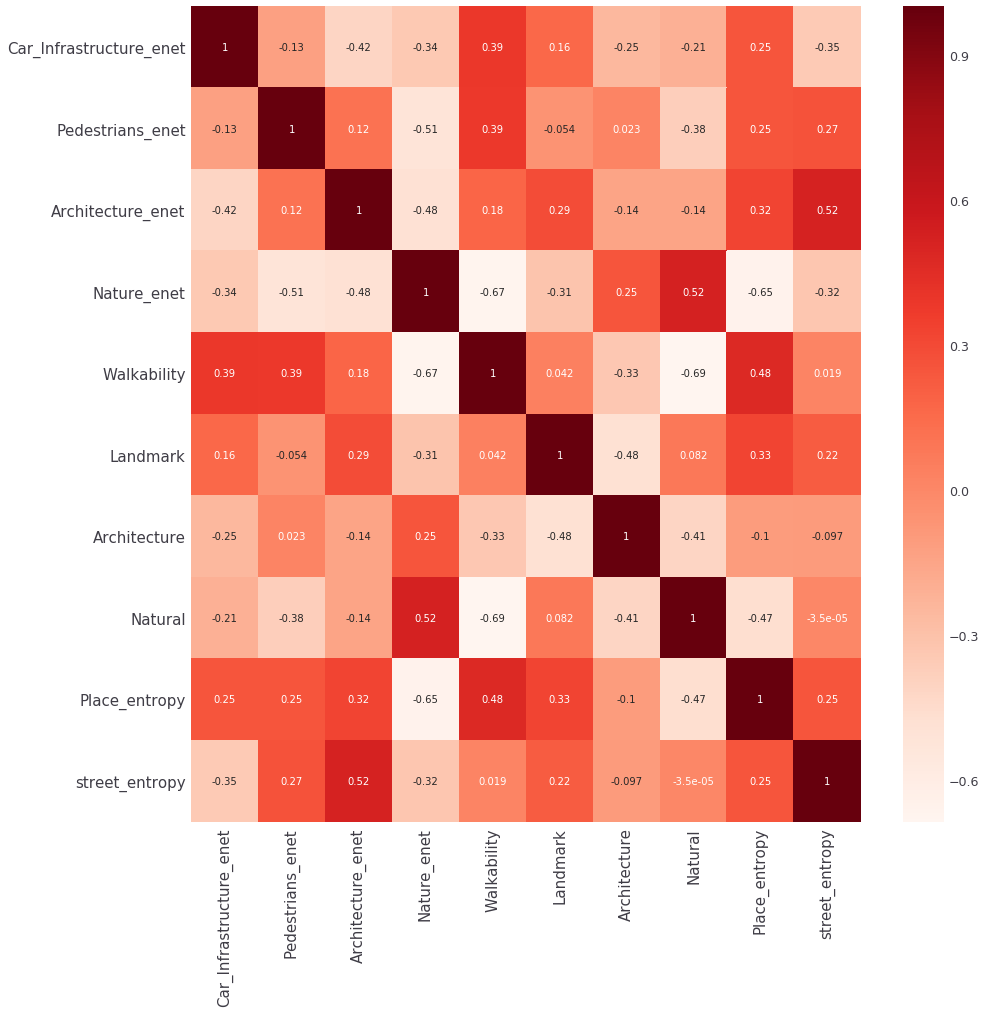

In [380]:
feats = city_mappilary_df.columns
fig, ax = plt.subplots(figsize=(15,15))         
corr = city_mappilary_df.corr(method='pearson')
sns.heatmap(corr, annot=True , ax=ax ,cmap='Reds' )
ax.set_xticklabels(corr.columns, fontsize=15)
ax.set_yticklabels(corr.columns, fontsize=15)

In [382]:
# city_mappilary_df.to_csv('scratchpad/city_mappilary_features_v2.csv')